<h3>Train NGCF Model</h3>

In [ ]:
import os
import math
from tqdm import tqdm
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score

data_dir = "/kaggle/input/movie-lens/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Hyperparams
EMB_DIM = 64
NGCF_LAYERS = [64, 64]
BATCH_SIZE = 2048
EPOCHS = 5
LR = 1e-3
EVAL_BATCH = 256
NEG_PER_POS = 1
ROC_NEG_SAMPLES = 100
TOPK = 50


train_matrix = sp.load_npz(os.path.join(data_dir, 'train_matrix.npz'))
test_matrix  = sp.load_npz(os.path.join(data_dir, 'test_matrix.npz'))
adj_matrix   = sp.load_npz(os.path.join(data_dir, 'adj_matrix.npz'))
user_to_idx  = np.load(os.path.join(data_dir, 'user_to_idx.npy'), allow_pickle=True).item()
movie_to_idx = np.load(os.path.join(data_dir, 'movie_to_idx.npy'), allow_pickle=True).item()

n_users, n_items = train_matrix.shape
n_nodes = n_users + n_items
print(f"n_users={n_users}, n_items={n_items}, n_nodes={n_nodes}")

def convert_sp_mat_to_sp_tensor(X):
    coo = X.tocoo()
    idx = np.vstack([coo.row, coo.col]).astype(np.int64)
    indices = torch.from_numpy(idx)
    values = torch.from_numpy(coo.data.astype(np.float32))
    return torch.sparse_coo_tensor(indices, values, X.shape).coalesce()

def normalize_adj(adj):
    adj = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj).dot(D_inv_sqrt)

norm_adj = normalize_adj(adj_matrix)
norm_adj_tensor = convert_sp_mat_to_sp_tensor(norm_adj).to(device)
print("Adjacency normalized and converted to sparse tensor.")


class NGCF(nn.Module):
    def __init__(self, n_users, n_items, adj, emb_dim=64, layers=[64,64]):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_nodes = n_users + n_items
        self.adj = adj

        self.embedding = nn.Embedding(self.n_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.W_msg = nn.ModuleList()
        self.W_self = nn.ModuleList()
        prev = emb_dim
        for ldim in layers:
            self.W_msg.append(nn.Linear(prev, ldim))
            self.W_self.append(nn.Linear(prev, ldim))
            prev = ldim

    def propagate(self, x):
        all_embeds = [x]
        h = x
        for Wm, Ws in zip(self.W_msg, self.W_self):
            h_neigh = torch.sparse.mm(self.adj, h)
            msg = Wm(h_neigh)
            self_trans = Ws(h)
            h = F.leaky_relu(msg + self_trans)
            all_embeds.append(h)
        return torch.cat(all_embeds, dim=1)

    def forward_emb(self):
        x = self.embedding.weight
        return self.propagate(x)

    def predict_logits(self, users, items):
        emb = self.forward_emb()
        user_emb = emb[users]
        item_emb = emb[self.n_users + items]
        return (user_emb * item_emb).sum(dim=1)


class LinkTrainDataset(Dataset):
    def __init__(self, train_sp):
        self.train = train_sp.tolil()
        self.n_users, self.n_items = train_sp.shape
        self.pos_pairs = [(u,i) for u in range(self.n_users) for i in self.train.rows[u]]
        self.user_pos_set = {u: set(self.train.rows[u]) for u in range(self.n_users)}

    def __len__(self):
        return len(self.pos_pairs)

    def __getitem__(self, idx):
        u, i_pos = self.pos_pairs[idx]
        while True:
            i_neg = np.random.randint(0, self.n_items)
            if i_neg not in self.user_pos_set[u]:
                break
        return u, i_pos, i_neg


def expand_batch(batch):
    users_pos = batch[0].numpy() if isinstance(batch[0], torch.Tensor) else np.array(batch[0])
    pos_items = batch[1].numpy() if isinstance(batch[1], torch.Tensor) else np.array(batch[1])
    neg_items = batch[2].numpy() if isinstance(batch[2], torch.Tensor) else np.array(batch[2])

    users = np.concatenate([users_pos, users_pos], axis=0)
    items = np.concatenate([pos_items, neg_items], axis=0)
    labels = np.concatenate([np.ones(len(pos_items), dtype=np.float32),
                             np.zeros(len(neg_items), dtype=np.float32)], axis=0)
    perm = np.random.permutation(len(users))
    return (torch.from_numpy(users[perm]).long(),
            torch.from_numpy(items[perm]).long(),
            torch.from_numpy(labels[perm]).float())


def evaluate_metrics(model, train_sp, test_sp, topk=TOPK, eval_batch=EVAL_BATCH,
                     roc_neg_samples=ROC_NEG_SAMPLES, device=device):
    model.eval()
    train_lil = train_sp.tolil()
    test_lil = test_sp.tolil()
    with torch.no_grad():
        full_emb = model.forward_emb().to(device)
        user_emb = full_emb[:n_users]
        item_emb = full_emb[n_users:]

    # ROC-AUC
    roc_scores, roc_labels = [], []
    users_with_test = [u for u in range(n_users) if len(test_lil.rows[u]) > 0]
    for u in tqdm(users_with_test, desc="ROC-AUC sampling", leave=False):
        test_items = test_lil.rows[u]
        if len(test_items) == 0: continue
        u_emb = user_emb[u].unsqueeze(0)
        pos_items_t = torch.tensor(test_items, dtype=torch.long).to(device)
        pos_logits = (u_emb * item_emb[pos_items_t]).sum(dim=1).cpu().numpy()
        roc_scores.extend(pos_logits.tolist())
        roc_labels.extend([1]*len(pos_logits))

        forbidden = set(train_lil.rows[u]).union(test_lil.rows[u])
        pool = [i for i in range(n_items) if i not in forbidden]
        if len(pool) == 0: pool = [i for i in range(n_items) if i not in set(train_lil.rows[u])]
        if len(pool) == 0: continue
        n_negs = min(len(pool), max(roc_neg_samples, len(pos_items_t)*roc_neg_samples))
        neg_sample = np.random.choice(pool, size=n_negs, replace=False)
        neg_items_t = torch.tensor(neg_sample, dtype=torch.long).to(device)
        neg_logits = (u_emb * item_emb[neg_items_t]).sum(dim=1).cpu().numpy()
        roc_scores.extend(neg_logits.tolist())
        roc_labels.extend([0]*len(neg_logits))

    try:
        roc_auc = roc_auc_score(roc_labels, roc_scores)
    except: roc_auc = float('nan')

    # Precision@K and Recall@K
    precisions, recalls = [], []
    user_indices = [u for u in range(n_users) if len(test_lil.rows[u])>0]
    n_batches = math.ceil(len(user_indices)/eval_batch)
    for b in tqdm(range(n_batches), desc="Ranking eval", leave=False):
        batch_users = user_indices[b*eval_batch:(b+1)*eval_batch]
        if not batch_users: continue
        u_emb_batch = user_emb[batch_users]
        scores = u_emb_batch @ item_emb.T
        for i_idx, u in enumerate(batch_users):
            titems = train_lil.rows[u]
            if len(titems)>0:
                scores[i_idx, titems] = -1e9
        topk_vals, topk_idx = torch.topk(scores, topk, dim=1)
        topk_idx = topk_idx.cpu().numpy()
        for i_idx, u in enumerate(batch_users):
            pred = topk_idx[i_idx]
            true_set = set(test_lil.rows[u])
            if len(true_set)==0: continue
            hits = len(set(pred) & true_set)
            precisions.append(hits/float(topk))
            recalls.append(hits/float(len(true_set)))

    precision_at_k = float(np.mean(precisions)) if precisions else 0.0
    recall_at_k = float(np.mean(recalls)) if recalls else 0.0
    return {"roc_auc": roc_auc, f"precision@{topk}": precision_at_k, f"recall@{topk}": recall_at_k}


dataset = LinkTrainDataset(train_matrix)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
model = NGCF(n_users, n_items, norm_adj_tensor, emb_dim=EMB_DIM, layers=NGCF_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss()

best_roc_auc = 0.0
save_path = "best_ngcf_model.pth"


for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
    for batch in pbar:
        u_batch, pos_batch, neg_batch = batch
        u_batch, i_batch, y_batch = expand_batch((u_batch, pos_batch, neg_batch))
        u_batch, i_batch, y_batch = u_batch.to(device), i_batch.to(device), y_batch.to(device)

        logits = model.predict_logits(u_batch, i_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    print(f"Epoch {epoch} Loss sum: {total_loss:.4f}")

    # Evaluation
    metrics = evaluate_metrics(model, train_matrix, test_matrix, topk=TOPK, eval_batch=EVAL_BATCH)
    roc_auc = metrics["roc_auc"]
    precision = metrics[f"precision@{TOPK}"]
    recall = metrics[f"recall@{TOPK}"]
    print(f"Epoch {epoch} evaluation: ROC-AUC={roc_auc:.4f}, Precision@{TOPK}={precision:.4f}, Recall@{TOPK}={recall:.4f}")

    # Autosave
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "roc_auc": roc_auc,
            "precision@k": precision,
            "recall@k": recall
        }, save_path)
        print(f"*** Saved new best model at epoch {epoch} with ROC-AUC={roc_auc:.4f} ***")

# Final evaluation
metrics = evaluate_metrics(model, train_matrix, test_matrix, topk=TOPK, eval_batch=EVAL_BATCH)
print("Final evaluation metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.6f}")

Using device: cuda
n_users=162541, n_items=59047, n_nodes=221588
Adjacency normalized and converted to sparse tensor.


Epoch 1/5: 100%|██████████| 9766/9766 [49:07<00:00,  3.31it/s, batch_loss=0.1157]  


Epoch 1 Loss sum: 1354.1573


Epoch 1 evaluation: ROC-AUC=0.9414, Precision@50=0.1332, Recall@50=0.1132
*** Saved new best model at epoch 1 with ROC-AUC=0.9414 ***


Epoch 2/5: 100%|██████████| 9766/9766 [49:04<00:00,  3.32it/s, batch_loss=0.1112]  


Epoch 2 Loss sum: 1062.8026


Epoch 2 evaluation: ROC-AUC=0.9457, Precision@50=0.1434, Recall@50=0.1236
*** Saved new best model at epoch 2 with ROC-AUC=0.9457 ***


Epoch 3/5: 100%|██████████| 9766/9766 [49:04<00:00,  3.32it/s, batch_loss=0.1010]  


Epoch 3 Loss sum: 961.7361


Epoch 3 evaluation: ROC-AUC=0.9456, Precision@50=0.1473, Recall@50=0.1267


Epoch 4/5: 100%|██████████| 9766/9766 [49:02<00:00,  3.32it/s, batch_loss=0.0816]


Epoch 4 Loss sum: 906.8385


Epoch 4 evaluation: ROC-AUC=0.9484, Precision@50=0.1505, Recall@50=0.1287
*** Saved new best model at epoch 4 with ROC-AUC=0.9484 ***


Epoch 5/5: 100%|██████████| 9766/9766 [49:04<00:00,  3.32it/s, batch_loss=0.1011]


Epoch 5 Loss sum: 867.9758


Epoch 5 evaluation: ROC-AUC=0.9461, Precision@50=0.1497, Recall@50=0.1294


Final evaluation metrics:
  roc_auc: 0.946133
  precision@50: 0.149672
  recall@50: 0.129430


<h3>Test NGCF Model</h3>

In [26]:
import torch.nn as nn
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, adj, emb_dim=64, layers=[64,64]):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_nodes = n_users + n_items
        self.adj = adj

        self.embedding = nn.Embedding(self.n_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.W_msg = nn.ModuleList()
        self.W_self = nn.ModuleList()
        prev = emb_dim
        for ldim in layers:
            self.W_msg.append(nn.Linear(prev, ldim))
            self.W_self.append(nn.Linear(prev, ldim))
            prev = ldim

    def propagate(self, x):
        all_embeds = [x]
        h = x
        for Wm, Ws in zip(self.W_msg, self.W_self):
            h_neigh = torch.sparse.mm(self.adj, h)
            msg = Wm(h_neigh)
            self_trans = Ws(h)
            h = F.leaky_relu(msg + self_trans)
            all_embeds.append(h)
        return torch.cat(all_embeds, dim=1)

    def forward_emb(self):
        x = self.embedding.weight
        return self.propagate(x)

    def predict_logits(self, users, items):
        emb = self.forward_emb()
        user_emb = emb[users]
        item_emb = emb[self.n_users + items]
        return (user_emb * item_emb).sum(dim=1)

def convert_sp_mat_to_sp_tensor(X):
    coo = X.tocoo()
    idx = np.vstack([coo.row, coo.col]).astype(np.int64)
    indices = torch.from_numpy(idx)
    values = torch.from_numpy(coo.data.astype(np.float32))
    return torch.sparse_coo_tensor(indices, values, X.shape).coalesce()

def normalize_adj(adj):
    adj = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj).dot(D_inv_sqrt)

In [27]:
import pandas as pd
import numpy as np
import torch
import scipy.sparse as sp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_sd = torch.load("models/best_ngcf_e4.pth", map_location=device,  
                      weights_only=False)["model_state_dict"]
n_users=162541
n_items=59047
adj_matrix = sp.load_npz(os.path.join(data_dir, 'adj_matrix.npz'))
norm_adj = normalize_adj(adj_matrix)
norm_adj_tensor = convert_sp_mat_to_sp_tensor(norm_adj).to(device)
model = NGCF(n_users=n_users, n_items=n_items, adj=norm_adj_tensor)
model.load_state_dict(model_sd)

data_dir = "preprocessed_data/"
user_to_idx = np.load(data_dir + "user_to_idx.npy", allow_pickle=True).item()
movie_to_idx = np.load(data_dir + "movie_to_idx.npy", allow_pickle=True).item()

idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_movie = {v: k for k, v in movie_to_idx.items()}
ratings_df = pd.read_csv("ratings.csv")
movies_df  = pd.read_csv("movies.csv")

movieId_to_title = dict(zip(movies_df["movieId"], movies_df["title"]))

item_idx_to_name = {
    idx: movieId_to_title.get(movieId, f"Unknown movie {movieId}")
    for movieId, idx in movie_to_idx.items()
}


def get_top_rated_movies(user_id_internal, top_n=5):
    """Return the user's top-N highest rated movies using ratings.csv."""
    # Convert internal id → real MovieLens userId
    real_user_id = idx_to_user[user_id_internal]
    
    # Get all user ratings
    user_ratings = ratings_df[ratings_df["userId"] == real_user_id]

    if user_ratings.empty:
        return []

    # Sort by rating descending
    user_ratings = user_ratings.sort_values("rating", ascending=False)

    # Take top N
    top = user_ratings.head(top_n)

    favorites = []
    for _, row in top.iterrows():
        movieId = row["movieId"]
        rating  = row["rating"]

        # Map movieId → internal item index (if exists)
        if movieId in movie_to_idx:
            item_idx = movie_to_idx[movieId]
            title = movieId_to_title.get(movieId, f"Unknown {movieId}")
            favorites.append((item_idx, title, rating))

    return favorites


def recommend_for_user(model, user_id_internal, train_matrix, k=20):
    model.eval()

    # User’s top 5 rated movies (from ratings.csv)
    favorites = get_top_rated_movies(user_id_internal, top_n=10)

    # Model predictions for unseen items
    with torch.no_grad():
        full_emb = model.forward_emb().to(device)
        user_emb = full_emb[:n_users]
        item_emb = full_emb[n_users:]

        u_emb = user_emb[user_id_internal].unsqueeze(0)
        scores = (u_emb @ item_emb.T).squeeze(0)

        # Mask seen interactions
        seen_items = set(train_matrix[user_id_internal].nonzero()[1])
        for iid in seen_items:
            scores[iid] = -1e9

        topk_values, topk_indices = torch.topk(scores, k)
        top_items = topk_indices.cpu().numpy()
        top_scores = topk_values.cpu().numpy()

    recommendations = []
    for iid, score in zip(top_items, top_scores):
        real_movie_id = idx_to_movie[iid]
        title = movieId_to_title.get(real_movie_id, f"Unknown {real_movie_id}")
        recommendations.append((iid, title, float(score)))

    return favorites, recommendations

In [31]:
import os
import torch.nn.functional as F

user_id = 162000  # internal index

train_matrix = sp.load_npz(os.path.join(data_dir, 'train_matrix.npz'))

favorites, recommendations = recommend_for_user(
    model=model,
    user_id_internal=user_id,
    train_matrix=train_matrix,
    k=20
)

print("=== Top 5 Highest-Rated Movies by User ===")
for iid, title, rating in favorites:
    print(f"{title}  — rated {rating}")

print("\n=== Model Recommendations ===")
for iid, title, score in recommendations:
    print(f"{title}  — score {score:.4f}")

=== Top 5 Highest-Rated Movies by User ===
Star Wars: Episode IV - A New Hope (1977)  — rated 5.0
Inside Out (2015)  — rated 5.0
Titanic (1997)  — rated 5.0
Life Is Beautiful (La Vita è bella) (1997)  — rated 5.0
Birdman: Or (The Unexpected Virtue of Ignorance) (2014)  — rated 5.0
Her (2013)  — rated 5.0
Wolf of Wall Street, The (2013)  — rated 5.0
Django Unchained (2012)  — rated 4.5
Avengers: Infinity War - Part II (2019)  — rated 4.5
Shutter Island (2010)  — rated 4.5

=== Model Recommendations ===
Lord of the Rings: The Fellowship of the Ring, The (2001)  — score 7.1661
Lord of the Rings: The Return of the King, The (2003)  — score 7.1544
Lord of the Rings: The Two Towers, The (2002)  — score 6.9927
Shawshank Redemption, The (1994)  — score 6.9068
Dark Knight, The (2008)  — score 6.8826
Matrix, The (1999)  — score 6.8041
Forrest Gump (1994)  — score 6.5403
Pirates of the Caribbean: The Curse of the Black Pearl (2003)  — score 6.4081
Inception (2010)  — score 6.2640
Fight Club (1999

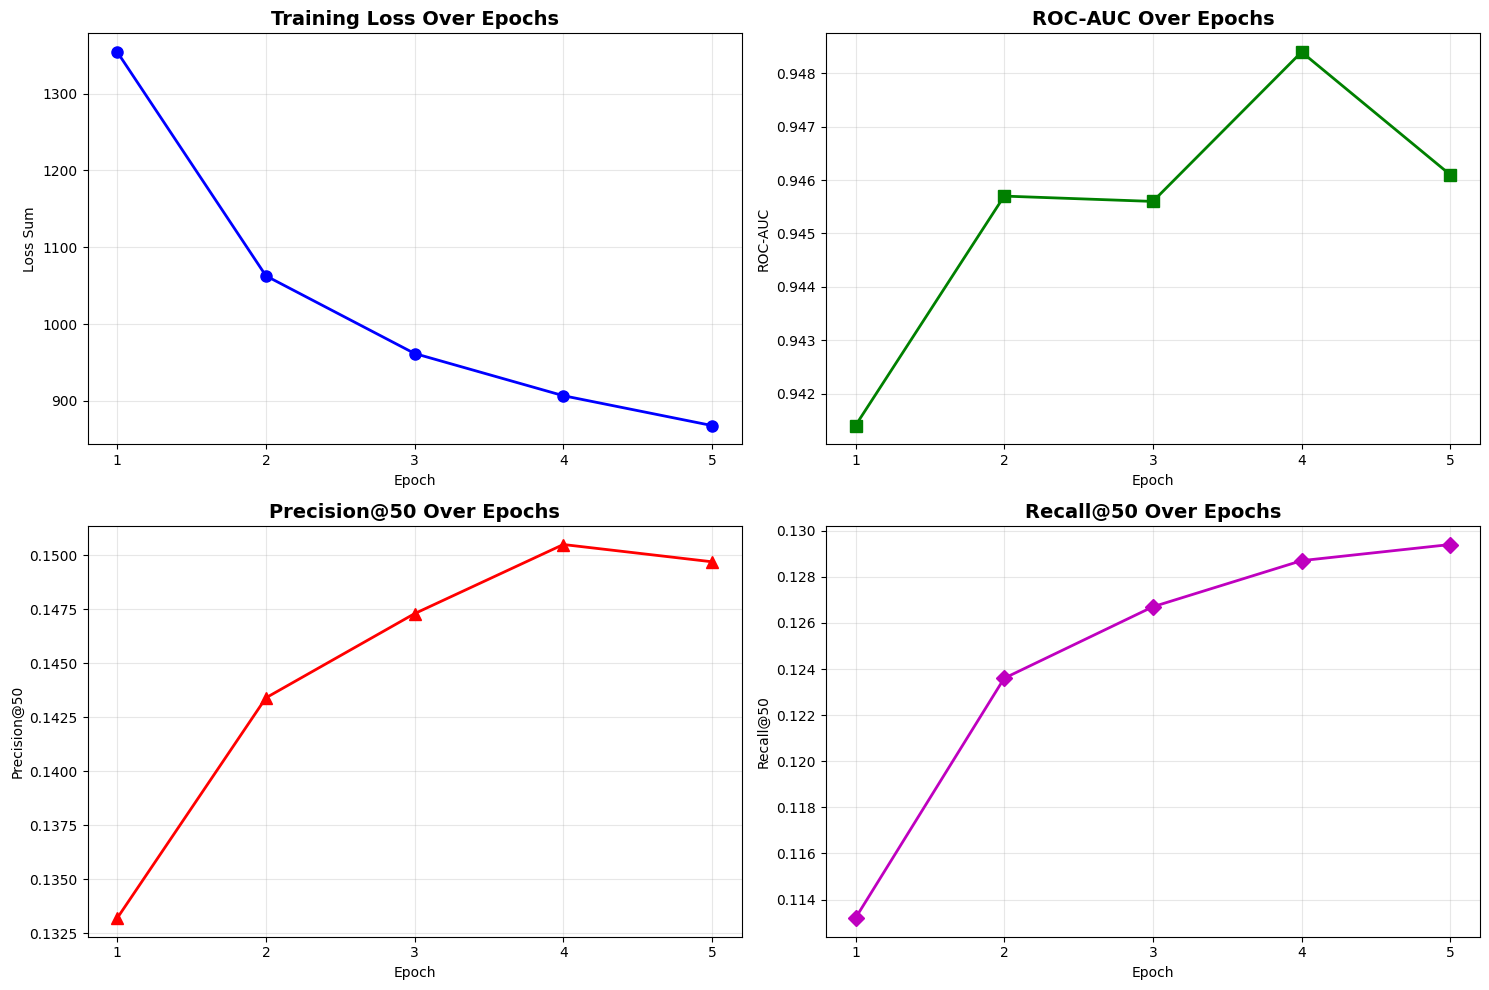

Training Summary:
Dataset: 162541 users, 59047 items, 221588 total nodes
Best results at epoch 4

Best ROC-AUC: 0.9484
Best Precision@50: 0.1505
Best Recall@50: 0.1287

Final ROC-AUC: 0.9461
Final Precision@50: 0.1497
Final Recall@50: 0.1294

Loss reduction: 35.9%


In [8]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
loss_sum = [1354.1573, 1062.8026, 961.7361, 906.8385, 867.9758]
roc_auc = [0.9414, 0.9457, 0.9456, 0.9484, 0.9461]
precision_50 = [0.1332, 0.1434, 0.1473, 0.1505, 0.1497]
recall_50 = [0.1132, 0.1236, 0.1267, 0.1287, 0.1294]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(epochs, loss_sum, 'b-o', linewidth=2, markersize=8)
ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Sum')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs)

ax2.plot(epochs, roc_auc, 'g-s', linewidth=2, markersize=8)
ax2.set_title('ROC-AUC Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('ROC-AUC')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs)

ax3.plot(epochs, precision_50, 'r-^', linewidth=2, markersize=8)
ax3.set_title('Precision@50 Over Epochs', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Precision@50')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(epochs)

ax4.plot(epochs, recall_50, 'm-D', linewidth=2, markersize=8)
ax4.set_title('Recall@50 Over Epochs', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Recall@50')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(epochs)

plt.tight_layout()
plt.show()

print("Training Summary:")
print(f"Dataset: {162541} users, {59047} items, {221588} total nodes")
print(f"Best results at epoch 4")
print(f"\nBest ROC-AUC: {roc_auc[3]}")
print(f"Best Precision@50: {precision_50[3]:.4f}")
print(f"Best Recall@50: {recall_50[3]:.4f}\n")
print(f"Final ROC-AUC: {roc_auc[4]}")
print(f"Final Precision@50: {precision_50[4]:.4f}")
print(f"Final Recall@50: {recall_50[4]:.4f}\n")
print(f"Loss reduction: {((loss_sum[0] - loss_sum[-1]) / loss_sum[0] * 100):.1f}%")